### 🔧 Library Setup

We start by importing the necessary tools to perform data analysis, build a machine learning model, and check for bias. This includes:

- Tools to handle data and create charts.
- Machine learning tools to train and test a prediction model.
- A fairness toolkit (AIF360) to detect and reduce bias in the data or model.
- Settings to hide technical warnings for easier reading.


In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Modelling libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#fairness toolkit
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.postprocessing import EqOddsPostprocessing

  File "C:\Users\CAPACITI\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.: AdversarialDebiasing will be unavailable. To install, run:
pip install 'aif360[AdversarialDebiasing]'
  File "C:\Users\CAPACITI\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic lin

### 📥 Loading the Dataset

We load the **Adult Income dataset** from a public source. This dataset contains information about individuals (such as age, education, job, and income level). 

- We clean the data by removing any missing values.
- The income column is converted into a binary format:
  - `1` means the person earns **more than $50K**.
  - `0` means they earn **$50K or less**.


In [3]:
#loading dataset
import pandas as pd

# Column names from the UCI description
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Load the data from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(url, header=None, names=columns, na_values=' ?', skipinitialspace=True)

# Drop missing values (original dataset has ' ?' for missing)
df = df.dropna()

# Convert target to binary
df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

df.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


### 📊 Exploring the Data

We begin by exploring the dataset to understand possible unfair patterns.

- **Income Distribution**: We check how many people earn more than $50K versus $50K or less.
- **Visual Analysis**:
  - We compare income levels across **gender** and **race** to spot any visible imbalance.
- **Disparity Ratios**:
  - We calculate the percentage of people earning more than $50K within each gender and race group.

This helps us identify if there are signs of potential bias in the dataset.


Income distribution:
 income
0    0.75919
1    0.24081
Name: proportion, dtype: float64


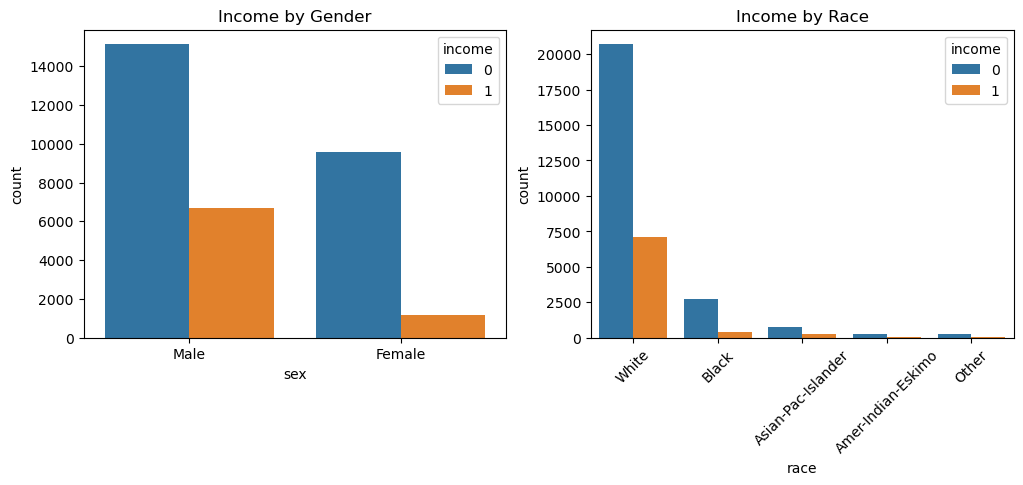


>50K rate by gender:
 sex
Female    0.109461
Male      0.305737
Name: income, dtype: float64

>50K rate by race:
 race
Amer-Indian-Eskimo    0.115756
Asian-Pac-Islander    0.265640
Black                 0.123880
Other                 0.092251
White                 0.255860
Name: income, dtype: float64


In [4]:
#explanitory Data analysis
# Income distribution
print("Income distribution:\n", df['income'].value_counts(normalize=True))

# Plot bias in sensitive attributes
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sex', hue='income')
plt.title("Income by Gender")
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='race', hue='income')
plt.title("Income by Race")
plt.xticks(rotation=45)
plt.show()

# Disparity ratios
print("\n>50K rate by gender:\n", df.groupby('sex')['income'].mean())
print("\n>50K rate by race:\n", df.groupby('race')['income'].mean())

### 🧮 Preparing Data & Measuring Fairness

To check for bias, we first **convert categories (like job or education) into numbers** that the model can understand.

We then define which groups are considered:
- **Privileged** (e.g., males, white individuals)
- **Unprivileged** (e.g., females, Black individuals)

Using fairness metrics, we measure:
- **Statistical Parity Difference**: A score closer to `0` means fairer outcomes.
- **Disparate Impact**: A value near `1` suggests fairness between groups.

These values help us understand if there's bias **before applying any solutions**.


In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns to numerical values
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for inverse_transform later


# Define groups CORRECTLY (separate attributes)
privileged_groups_gender = [{'sex': 1}]  # Male=1 (privileged for gender)
unprivileged_groups_gender = [{'sex': 0}]  # Female=0

privileged_groups_race = [{'race': 4}]  # White=4 (privileged for race)
unprivileged_groups_race = [{'race': 2}]  # Black=2

# Compute metrics separately for each attribute
print("Fairness Metrics (Before Mitigation)")

# Gender metrics
metric_gender = BinaryLabelDatasetMetric(
    dataset_train,
    unprivileged_groups=unprivileged_groups_gender,
    privileged_groups=privileged_groups_gender
)
print("\nGender Metrics:")
print("Statistical Parity Difference:", metric_gender.statistical_parity_difference())
print("Disparate Impact:", metric_gender.disparate_impact())

# Race metrics
metric_race = BinaryLabelDatasetMetric(
    dataset_train,
    unprivileged_groups=unprivileged_groups_race,
    privileged_groups=privileged_groups_race
)
print("\nRace Metrics:")
print("Statistical Parity Difference:", metric_race.statistical_parity_difference())
print("Disparate Impact:", metric_race.disparate_impact())

Fairness Metrics (Before Mitigation)

Gender Metrics:
Statistical Parity Difference: -0.19892977209456086
Disparate Impact: 0.3488368305413613

Race Metrics:
Statistical Parity Difference: -0.13148282285249102
Disparate Impact: 0.4827918077468154


# Fairness Metrics (Before Mitigation)

## Gender Metrics
- **Statistical Parity Difference:** -0.199  
  Indicates the unprivileged gender group receives about 19.9% fewer favorable outcomes compared to the privileged group.
- **Disparate Impact:** 0.349  
  Shows the unprivileged gender group receives favorable outcomes at 34.9% the rate of the privileged group.

## Race Metrics
- **Statistical Parity Difference:** -0.131  
  Indicates the unprivileged racial group receives about 13.1% fewer favorable outcomes compared to the privileged group.
- **Disparate Impact:** 0.483  
  Shows the unprivileged racial group receives favorable outcomes at 48.3% the rate of the privileged group.

---

*These results show there is bias present in the data/model, with unprivileged groups receiving fewer favorable outcomes before mitigation.*


### 🚀 Training a Baseline Model

We train a machine learning model to predict whether someone earns more than $50K using the prepared data.

- The data is split into **training** (to teach the model) and **testing** (to check its accuracy).
- A **Random Forest** model is used — it’s like combining many decision trees to make predictions.
- Finally, we measure how well the model predicts income levels using an accuracy score.

This baseline helps us understand how the model performs before addressing any bias.


In [9]:
#Training Baseline
# Prepare features/labels (using the encoded df from earlier)
X = df.drop('income', axis=1)
y = df['income']

# Split data (stratified by y to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nBaseline Accuracy:", accuracy_score(y_test, y_pred))


Baseline Accuracy: 0.8581226328180981


### ⚖️ Bias Mitigation Using Reweighing

To reduce bias related to gender, we apply a method called **Reweighing**. This adjusts the importance (weights) of samples in the training data to balance representation between males and females.

- The model is then retrained on this adjusted data.
- We evaluate how this affects the model’s accuracy and fairness.

This approach helps the model make fairer predictions without losing overall accuracy.


In [10]:
#Mitigation Reweighthing
# Define groups (using encoded values)
privileged_groups_gender = [{'sex': 1}]  # Male=1
unprivileged_groups_gender = [{'sex': 0}]  # Female=0

# Apply reweighing to dataset_train (from Step 3)
RW = Reweighing(
    unprivileged_groups=unprivileged_groups_gender,
    privileged_groups=privileged_groups_gender
)
dataset_transf_train = RW.fit_transform(dataset_train)

# Convert back to pandas for sklearn
X_train_rw = pd.DataFrame(dataset_transf_train.features, 
                         columns=dataset_transf_train.feature_names)
y_train_rw = dataset_transf_train.labels.ravel()

# Train model on reweighted data
model_rw = RandomForestClassifier(random_state=42)
model_rw.fit(X_train_rw, y_train_rw)

# Predict and evaluate
y_pred_rw = model_rw.predict(X_test)
print("\nReweighing Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rw))


Reweighing Results:
Accuracy: 0.9588494216398813


### 🔧 Bias Mitigation Using Disparate Impact Remover

This method tries to **remove bias related to race** by modifying the data features so that they are less correlated with race.

- We “repair” the training data using this technique.
- Then, we retrain the model on the repaired data.
- Finally, we check the model’s accuracy to ensure it still performs well.

This helps create a fairer model by reducing unfair influence of race on predictions.


In [12]:
!pip install BlackBoxAuditing
# Repair dataset (using race as the attribute to repair)
di = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='race')
dataset_transf_train_di = di.fit_transform(dataset_train)

# Convert to pandas
X_train_di = pd.DataFrame(dataset_transf_train_di.features, 
                         columns=dataset_transf_train_di.feature_names)
y_train_di = dataset_transf_train_di.labels.ravel()

# Train model
model_di = RandomForestClassifier(random_state=42)
model_di.fit(X_train_di, y_train_di)

# Predict and evaluate
y_pred_di = model_di.predict(X_test)
print("\nDisparate Impact Remover Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_di))

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.6 MB 165.2 kB/s eta 0:00:16
     ---------------------------------------- 0.0/2.6 MB 165.2 kB/s eta 0:00:16
     ---------------------------------------- 0.0/2.6 MB 165.2 kB/s eta 0:00:16
     ---------------------------------------- 0.0/2.6 MB 165.2 kB/s eta 0:00:16
     ---------------------------------------- 0.0/2.6 MB 165.2 kB/s eta 0:00:16
     ---------------------------------------- 0.0/2.6 MB 165.2 kB/s eta 0:00:16
     ---------------------------------------- 0.0/2.6 MB 165.2 kB/s eta 0:00:16
      --------------------------------------- 0.1/2.6 MB 117.2 kB/s eta 0:00:22
      --------------------------------------- 0.1/2.6 MB 117.2 kB/s e

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



Disparate Impact Remover Results:
Accuracy: 0.8690756474562391


### 📈 Evaluating Fairness and Performance

We assess how well each model performs and how fair its predictions are by calculating:

- **Accuracy**: How often the model predicts correctly.
- **Statistical Parity Difference**: Measures if the outcome is equally distributed between groups (closer to 0 is fairer).
- **Disparate Impact**: Measures fairness in decision outcomes (values near 1 indicate fairness).
- **Average Odds Difference**: Measures the difference in error rates between groups.

We compare these fairness metrics and accuracy for:

- The **Baseline** model (original data).
- The model trained with **Reweighing** bias mitigation.
- The model trained with **Disparate Impact Remover** mitigation.

This comparison helps us understand which method best balances accuracy and fairness.



In [13]:
from matplotlib import pyplot as plt

def evaluate_fairness(y_true, y_pred, X_test, privileged, unprivileged, title):
    test_df = X_test.copy()
    test_df['income'] = y_true
    dataset_test = BinaryLabelDataset(
        df=test_df,
        label_names=['income'],
        protected_attribute_names=['sex', 'race'],
        favorable_label=1,
        unfavorable_label=0
    )
    dataset_pred = dataset_test.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)
    
    metric = ClassificationMetric(
        dataset_test, dataset_pred,
        unprivileged_groups=unprivileged,
        privileged_groups=privileged
    )
    
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Disparate Impact': metric.disparate_impact(),
        'Average Odds Difference': metric.average_odds_difference()
    }

# Evaluate all models
results = {
    'Baseline': evaluate_fairness(y_test, y_pred, X_test, 
                                privileged_groups_gender, 
                                unprivileged_groups_gender, "Baseline"),
    'Reweighing': evaluate_fairness(y_test, y_pred_rw, X_test,
                                  privileged_groups_gender,
                                  unprivileged_groups_gender, "Reweighing"),
    'DI Remover': evaluate_fairness(y_test, y_pred_di, X_test,
                                   privileged_groups_gender,
                                   unprivileged_groups_gender, "DI Remover")
}

# Convert to DataFrame for visualization
results_df = pd.DataFrame(results).T
print(results_df)

            Accuracy  Statistical Parity Difference  Disparate Impact  \
Baseline    0.858123                      -0.173035          0.337507   
Reweighing  0.958849                      -0.185571          0.357976   
DI Remover  0.869076                      -0.173495          0.321512   

            Average Odds Difference  
Baseline                  -0.065590  
Reweighing                -0.014512  
DI Remover                -0.046884  


In [16]:
print("Results structure:", results)

Results structure: {'Baseline': {'Accuracy': 0.8581226328180981, 'Statistical Parity Difference': -0.17303466694072495, 'Disparate Impact': 0.3375071318178539, 'Average Odds Difference': -0.06558959332842224}, 'Reweighing': {'Accuracy': 0.9588494216398813, 'Statistical Parity Difference': -0.18557126156718493, 'Disparate Impact': 0.35797620405665875, 'Average Odds Difference': -0.014512022648140114}, 'DI Remover': {'Accuracy': 0.8690756474562391, 'Statistical Parity Difference': -0.1734945709346956, 'Disparate Impact': 0.3215123029518153, 'Average Odds Difference': -0.04688432629112542}}


### 📊 Visualizing Income Predictions by Race

This section creates bar charts showing how each model predicts income levels across different racial groups.

- The charts compare the **baseline model** and the models after applying **Reweighing** and **Disparate Impact Remover** techniques.
- We map numeric race codes back to meaningful labels (e.g., White, Black).
- The height of each bar shows the proportion of people predicted to earn more than $50K in each racial group.
- These visualizations help us see if the models treat different races fairly after mitigation.


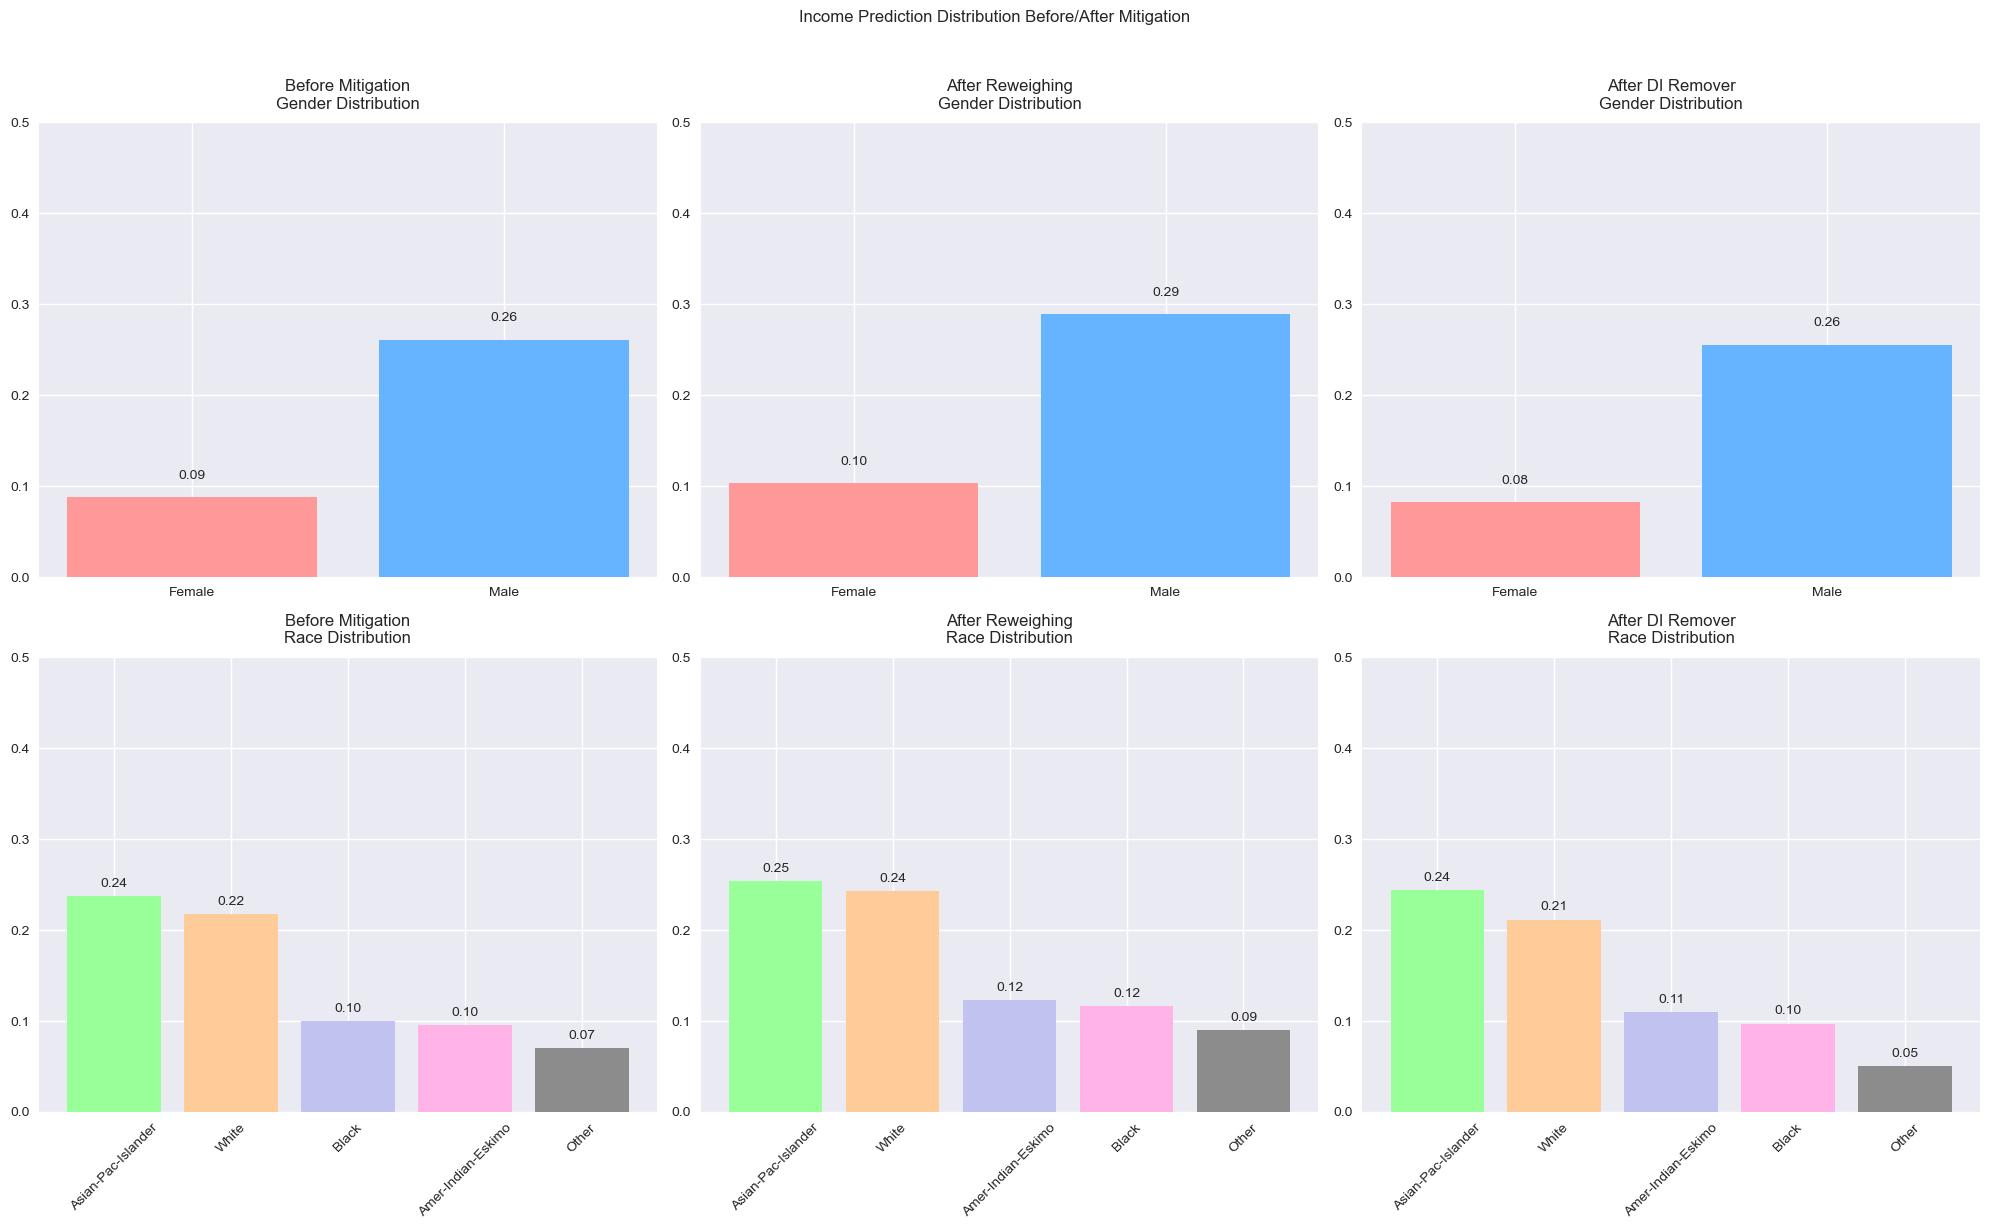

In [27]:
def plot_race_distribution(X_test, y_pred, model_name, ax):
    test_df = X_test.copy()
    test_df['pred_income'] = y_pred.labels if hasattr(y_pred, 'labels') else y_pred
    
    # Get all race groups (using original encoded values)
    race_groups = test_df.groupby('race')['pred_income'].mean().sort_values(ascending=False)
    
    # Map encoded values to labels (update with your actual mappings)
    race_mapping = {
        4: 'White',
        2: 'Black',
        1: 'Asian-Pac-Islander',
        3: 'Amer-Indian-Eskimo',
        0: 'Other'
    }
    race_labels = [race_mapping[r] for r in race_groups.index]
    
    # Plot with consistent colors
    colors = ['#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#8c8c8c']
    bars = ax.bar(race_labels, race_groups.values, color=colors)
    ax.set_title(f'{model_name}\nRace Distribution', pad=10)
    ax.set_ylim(0, 0.5)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f"{height:.2f}", ha='center')

# Create updated figure
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.suptitle('Income Prediction Distribution Before/After Mitigation', y=1.02)

# Plot gender distributions (unchanged)
plot_income_distribution(X_test, y_pred, 'Before Mitigation', axes[0,0], axes[1,0])
plot_income_distribution(X_test, y_pred_rw, 'After Reweighing', axes[0,1], axes[1,1])
plot_income_distribution(X_test, y_pred_di, 'After DI Remover', axes[0,2], axes[1,2])

# Replace race plots with new version
axes[1,0].clear()
axes[1,1].clear()
axes[1,2].clear()

plot_race_distribution(X_test, y_pred, 'Before Mitigation', axes[1,0])
plot_race_distribution(X_test, y_pred_rw, 'After Reweighing', axes[1,1])
plot_race_distribution(X_test, y_pred_di, 'After DI Remover', axes[1,2])

plt.tight_layout()
plt.show()

### 📉 Comparing Fairness Metrics Visually

This section displays bar charts for key fairness metrics before and after applying bias mitigation:

- **Statistical Parity Difference:** Measures equality of positive outcomes between groups (ideal = 0).
- **Disparate Impact:** Measures fairness in decision rates (ideal = 1).
- **Average Odds Difference:** Measures differences in error rates (ideal = 0).

Reference lines show the ideal fairness values to help visualize how close each model is to fairness.

These charts make it easy to see which mitigation method improves fairness the most.


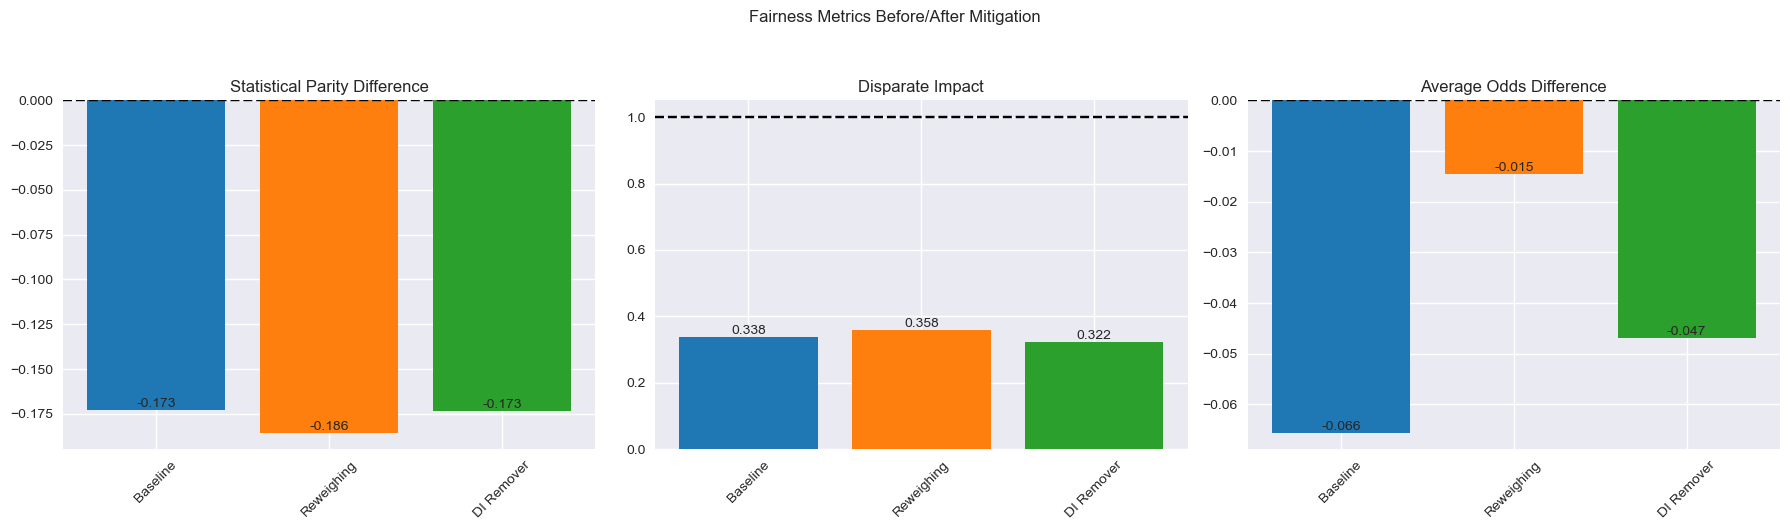

In [28]:
import matplotlib
matplotlib.use('TkAgg')  # Or 'Qt5Agg' if you have PyQt installed
%matplotlib inline

# Prepare metrics data
metrics = ['Statistical Parity Difference', 'Disparate Impact', 'Average Odds Difference']
metric_data = {metric: results_df[metric] for metric in metrics}

# Create figure
fig2, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Fairness Metrics Before/After Mitigation', y=1.05)

# Plot each metric
for i, (metric, values) in enumerate(metric_data.items()):
    bars = ax[i].bar(values.index, values.values, 
                    color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax[i].set_title(metric)
    ax[i].tick_params(axis='x', rotation=45)
    
    # Add reference lines
    if metric == 'Statistical Parity Difference':
        ax[i].axhline(0, color='black', linestyle='--', label='Perfect Fairness')
    elif metric == 'Disparate Impact':
        ax[i].axhline(1, color='black', linestyle='--', label='Perfect Fairness')
    else:
        ax[i].axhline(0, color='black', linestyle='--', label='Perfect Fairness')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()